**Examining the effect of the latent space dimension**

In this notebook, the effect of the latent space dimension is examined *(i.e., the value of the parameter latent_space_dimension)*, while using the following structures:

- **Encoder**: The encoder gets an input image with dimensions (64, 64, 3), and a series of convolutional and max-pooling layers are applied. The layers progressively reduce the spatial dimensions. On the other hand, the number of filters increases in each layer such that:
    - 16 filters in the first layer,
    - 32 filters in the second layer, 
    - 64 filters in the third layer,
    - 128 filters in the fourth layer.
    Each convolutional layer is followed by a max-pooling layer with a (2, 2) pooling size. The output from the last pooling layer is flattened to create a 1D vector. Then mean and log-variance that both have a size of latent_space_dimension are created.

- **Sampling**: Creating a latent space vector having a size of latent_space_dimension from mean and log-variance to be fed into the decoder. *Note that in HP3, latent_space_dimension is determined to be 16.* In this notebook, the following latent space dimensions are used: 
    - 2
    - 4
    - 8 
    - 16
    - 32

- **Decoder**: The decoder takes a latent space vector as an input. Series of convolutional and upsampling layers are applied to gradually reconstruct an output image with dimensions (64, 64, 3). The layers progressively increase the spatial dimensions while reducing the number of filters such that
    - 128 filters in the first layer,
    - 64 filters in the second layer,
    - 32 filters in the third layer,
    - 16 filters in the fourth layer.
    Each convolutional layer is followed by batch normalization and a Leaky ReLU activation. The final layer produces the reconstructed image.

In [1]:
# Import the modules necessary
import time 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import PIL.Image
import keras.backend as K
import glob, os
import random
from PIL import Image as Im

2023-08-12 17:50:06.687178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the space dimension list whose elements are used to define the bottleneck of the architecture (latent space)
latent_space_dimension_list = [2,4,8,16,32]

#### 1. Load data from image files (1000 pictures)

In [3]:
# Get the parent directory
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Construct the path to the 'data' folder
data_folder_path = os.path.join(parent_directory, 'data', 'datav64')

In [4]:
# The folder name for the pictures supplied
foldername=data_folder_path

# Number of pictures to work with
number_of_pics = 1000

# Create an counter to stop the for loop below when # number_of_pics is reached
counter = 0

# Create an empty list to store the name of pictures so that we can know which pics we are using
sample_pics_names = [0] * number_of_pics

# Create an empty array to store pictures (image size is 64 x 64 x 4 but channel number will be changed to 3)
sample_pics = np.empty((number_of_pics,64,64,3))

# adding images as arrays to the negative_image_arrays
index = 0
for images in os.listdir(foldername):
    if images.endswith(".png"):
        # get the individual image path
        image_path = os.path.join(foldername,images)
        # open the image
        img = Im.open(image_path)
        # get it as an array 
        img_array = np.array(img)
        # Getting rid of the alpha channel
        img_array = img_array[:, :,:3]
        # Normalization of the array 
        new_img = (img_array - np.min(img_array)) / (np.max(img_array)-np.min(img_array))
        # Returning it back to array
        normalized_img_array= np.array(new_img)
        # adding it to the arrays
        sample_pics_names[counter] = str(images)
        sample_pics[counter,:,:,:] = normalized_img_array 
        # increasing the counter
        counter += 1
    if counter == number_of_pics: 
        break
        
# Check how many pics that we stored in the lists
print("Number of sample pictures that are used:", len(sample_pics_names))
# Check whether the matplotlib.image.imread yields arrays indeed... 
print("The matplotlib.image.imread function yields: ", type(sample_pics[0]))
# Check the size of the array after reading it with matplotlib.image.imread 
image_shape = sample_pics[0].shape
print("The shape of the array for the images: ", image_shape)

Number of sample pictures that are used: 1000
The matplotlib.image.imread function yields:  <class 'numpy.ndarray'>
The shape of the array for the images:  (64, 64, 3)


In [5]:
# Create a tensorflow dataset 
batch_size = 64 # pictures will be batched by size of 64 (except the last batch)
# Each element in the array corresponds to one element using from_tensor_slices
dataset = tf.data.Dataset.from_tensor_slices(sample_pics).batch(batch_size).shuffle(132) 
# Shuffle function providing a diverse and randomized order of elements 

2023-08-12 17:50:15.407811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**2. Build the Autoencoder**

In [6]:
# Firstly, create the Encoder whose output is mean and log-variance

# Start with the Input layer (encoder_inputs) whose size is image_shape (64,64,3) 
encoder_inputs = layers.Input(shape = (64,64,3))

# Applying some filters, pooling etc. 
x = layers.Conv2D(filters = 16, kernel_size = (2,2), activation = 'relu', padding = 'same')(encoder_inputs) # Input is encoder_inputs
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 64, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x) # Input is x - connected 
x = layers.Flatten()(x) # Flattening the network to go from Conv2D to 1D space

# Creating 2 dense layers after flattening to represent mean and log-variance of the network created above
# These layers are stored in dictionaries (Keys corresponding to the values in latent_space_dimension_list, values are the architectures)
mean_dict = dict()
log_var_dict = dict()

# looping through each element in latent_space_dimension_array
for latent_space_dimension in latent_space_dimension_list: 
    mean_dict[latent_space_dimension] = layers.Dense(latent_space_dimension)(x)
    log_var_dict[latent_space_dimension] = layers.Dense(latent_space_dimension)(x)

# Checking the keys of the dictionaries, if they correspond to the elements in latent_space_dimension_list
print("Checking the keys of the dictionaries whether they correspond to the elements in latent_space_dimension_list:")
print("For the mean_dict, the keys are: ",list(mean_dict.keys()))
print("For log_var_dict, the keys are: : ",list(log_var_dict.keys()))

Checking the keys of the dictionaries whether they correspond to the elements in latent_space_dimension_list:
For the mean_dict, the keys are:  [2, 4, 8, 16, 32]
For log_var_dict, the keys are: :  [2, 4, 8, 16, 32]


In [7]:
# Creating a layer named as Sampling whose function is to get the mean and log variance from the encoder 
# and then creating a random noise epsilon, and finally return z (output of the sampling)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs;
        batch_size = tf.shape(z_mean)[0]
        dimension = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape = (batch_size, dimension))
        return z_mean + tf.exp(z_log_var * 0.5) * epsilon

In [8]:
# Connecting the Encoder with Sampling Layer, and thus creating len(latent_space_dimension_list) encoder architectures
# Also storing encoder architectures in a dictionaries
encoder_dict = dict()
for latent_space_dimension in latent_space_dimension_list: 
    mean = mean_dict[latent_space_dimension]
    log_var = log_var_dict[latent_space_dimension]
    output_sampling = Sampling()([mean, log_var])
    encoder = tf.keras.Model(encoder_inputs, [mean,log_var,output_sampling],name = f"Encoder_with_latent_space_of_{latent_space_dimension}")
    encoder_dict[latent_space_dimension] = encoder

# Checking different architectures stored in encoder_dict: 
print("DISPLAYING DIFFERENT ENCODER ARCHITECTURES: ")
print()
for space_dim in encoder_dict: 
    print(f"The dimension of the latent space is: {space_dim}")
    encoder = encoder_dict[space_dim]
    print("The encoder structure is as follows: ")
    encoder.summary()
    print("****************************************************************************************************************")
    print("****************************************************************************************************************")
    print("****************************************************************************************************************")    
    

DISPLAYING DIFFERENT ENCODER ARCHITECTURES: 

The dimension of the latent space is: 2
The encoder structure is as follows: 
Model: "Encoder_with_latent_space_of_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 3

 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 15, 15, 32)  0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   8256        ['max_pooling2d_1[0][0]']        
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 7, 7, 64)    0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 

                                                                                                  
 conv2d_3 (Conv2D)              (None, 6, 6, 128)    32896       ['max_pooling2d_2[0][0]']        
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 3, 3, 128)   0           ['conv2d_3[0][0]']               
                                                                                                  
 flatten (Flatten)              (None, 1152)         0           ['max_pooling2d_3[0][0]']        
                                                                                                  
 dense_8 (Dense)                (None, 32)           36896       ['flatten[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           36896       ['flatten[0][0]']                
          

In [9]:
# Create decoder_dict to store different decoder architectures corresponding to the the number of elements in latent_space_dimension_list
decoder_dict = dict()

# Loop through each latent_space_dimension in latent_space_dimension_list to create decoder architectures
for latent_space_dimension in latent_space_dimension_list: 
    # Create the decoder (the input shape to the decoder is the shape of latent space)
    decoder_inputs = layers.Input(shape = (latent_space_dimension,))
    x = layers.Dense(8*8*8, activation = 'relu')(decoder_inputs)
    x = layers.Reshape((8,8,8))(x)
    x = layers.Conv2D(filters = 128, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.UpSampling2D()(x) 
    x = layers.Conv2D(filters = 64, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.UpSampling2D()(x) 
    x = layers.Conv2D(filters = 32, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.UpSampling2D()(x) 
    x = layers.Conv2D(filters = 16, kernel_size = (2,2), padding = 'same',activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(filters = 3, kernel_size = (2,2), padding = 'same')(x) # 3 channels
    decoder = tf.keras.Model(decoder_inputs, x, name = f"Decoder_with_latent_space_of_{latent_space_dimension}")
    decoder_dict[latent_space_dimension]=decoder

# Checking different architectures stored in decoder_dict: 
print("DISPLAYING DIFFERENT DECODER ARCHITECTURES: ")
print()
for space_dim in decoder_dict: 
    print(f"The dimension of the latent space is: {space_dim}")
    decoder = decoder_dict[space_dim]
    print("The decoder structure is as follows: ")
    decoder.summary()
    print("****************************************************************************************************************")
    print("****************************************************************************************************************")
    print("****************************************************************************************************************")    
    

DISPLAYING DIFFERENT DECODER ARCHITECTURES: 

The dimension of the latent space is: 2
The decoder structure is as follows: 
Model: "Decoder_with_latent_space_of_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 512)               1536      
                                                                 
 reshape (Reshape)           (None, 8, 8, 8)           0         
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         4224      
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                            

                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 8)           0         
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         4224      
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 batch_nor

                                                                 
 up_sampling2d_12 (UpSamplin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 up_sampling2d_13 (UpSamplin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        8224      
          

In [10]:
# Create a dictionary to store all architectures composing of encoder & decoder 
architectures = dict()

# Loop through each latent_space_dimension
for latent_space_dimension in latent_space_dimension_list: 
    # Get the encoder
    encoder = encoder_dict[latent_space_dimension]
    # Get the decoder
    decoder = decoder_dict[latent_space_dimension]
    # Combine the whole architecture encoder & decoder 
    inp = encoder.input
    out = encoder.output
    decoder_output = decoder(out[2])
    vae = tf.keras.Model(inp, decoder_output,name= f"Combined_architecture_with_latent_space_of_{latent_space_dimension}")
    architectures[latent_space_dimension] = vae
    
# Checking different architectures stored in architectures: 
print("DISPLAYING DIFFERENT ARCHITECTURES: ")
print()
for space_dim in architectures: 
    print(f"The dimension of the latent space is: {space_dim}")
    vae = architectures[space_dim]
    print("The overall architecture is as follows: ")
    vae.summary()
    print("****************************************************************************************************************")
    print("****************************************************************************************************************")
    print("****************************************************************************************************************")    
    

DISPLAYING DIFFERENT ARCHITECTURES: 

The dimension of the latent space is: 2
The overall architecture is as follows: 
Model: "Combined_architecture_with_latent_space_of_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (No

__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                                                  
 max_pooli

 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 31, 31, 32)   2080        ['max_pooling2d[0][0]']          
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 15, 15, 32)  0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 

**3. Define the Loss Function**

In this sections, train and train_steps functions modified such that they work with the given encoder, decoder, vae (overall) architectures. 

Also latent visualize function modified such that it generates the results given the latent_space_dim. 

Besides, train function is modified such that it keeps the record of average loss for each epoch. 

In [11]:
# define loss functions
def kl_loss(z_log_var,z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return kl_loss * 0.012

loss = tf.keras.losses.BinaryCrossentropy()
def reconstruction_loss(data,reconstructed):
    return loss(data,reconstructed)

optimizer = tf.keras.optimizers.Adam()  

In [12]:
# Train model using GRADIENT TAPE
def train_steps(data,encoder,decoder,vae): 
    total_loss = 0
    with tf.GradientTape() as vae_tape:
        z_mean,z_log_var,z = encoder(data)
        reconstructed_image = decoder(z)
        kl_ = kl_loss(z_log_var,z_mean)
        reconstruction_ = reconstruction_loss(data, reconstructed_image)
        total_loss = kl_ + reconstruction_
    gradient2 = vae_tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradient2, vae.trainable_variables))
    return total_loss

In [13]:
# visualize results from epoch 
def visualize(epoch,):
    noise = tf.keras.backend.random_normal(shape = (9,latent_space_dim))
    prediction = decoder(noise)
    plt.figure(figsize = (5,5))
    for i in range(9):
        if(i == 2):
            plt.title(", Epoch: {}".format(,epoch))
        plt.subplot(3,3,i+1)
        plt.imshow(prediction[i],cmap = 'gray')
        plt.axis('off')
        # Save the plot to the generated folder
        file_path = os.path.join(f'generated', 'generated_plot_epoch_{}.png'.format(epoch))
        plt.savefig(file_path)

In [14]:
# create training function
def train(dataset,encoder,decoder,vae,latent_space_dim,epochs,start_epoch=0):

    loss_history = [] # To store loss values for each epoch

    for epoch in range(epochs):
        start = time.time()
        epoch_losses = []  # To store loss values for each batch in the epoch

        for batch in dataset:
            total_loss = train_steps(batch, encoder, decoder, vae)
            # Append the mean of total_loss for each batch
            epoch_losses.append(np.sum(total_loss)/(total_loss.shape[0] * total_loss.shape[1]))
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses) # Calculate the average loss for the epoch
        loss_history.append(avg_epoch_loss)  # Store the average loss in the loss_history list

        print("Epoch: {} Time: {} Avg Loss: {}".format(epoch+1, np.round(time.time()-start, 2), avg_epoch_loss))

        if epoch % 10 == 0:
            visualize(epoch+1+start_epoch, latent_space_dim)
        
    return loss_history  # Return the list of average epoch losses


In [15]:
# Create a dictionary to store loss_history during epochs for each element in latent_space_dim
loss_dict = dict()

STARTED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF:  2
Epoch: 1 Time: 7.3 Avg Loss: 1.8047044903039933
Epoch: 2 Time: 6.97 Avg Loss: 0.8151546202600002
Epoch: 3 Time: 6.86 Avg Loss: 0.7594203218817711
Epoch: 4 Time: 6.99 Avg Loss: 0.7352542027831077
Epoch: 5 Time: 7.53 Avg Loss: 0.7192795790731907
Epoch: 6 Time: 7.54 Avg Loss: 0.7087641544640064
Epoch: 7 Time: 6.92 Avg Loss: 0.7004698373377323
Epoch: 8 Time: 6.96 Avg Loss: 0.6952886462211609
Epoch: 9 Time: 6.96 Avg Loss: 0.6926280833780766
Epoch: 10 Time: 6.92 Avg Loss: 0.6907944314181804
Epoch: 11 Time: 6.96 Avg Loss: 0.6896101698279381
Epoch: 12 Time: 6.91 Avg Loss: 0.6887610711157321
Epoch: 13 Time: 6.95 Avg Loss: 0.6881547428667545
Epoch: 14 Time: 6.92 Avg Loss: 0.6876458272337913
Epoch: 15 Time: 6.89 Avg Loss: 0.6872654564678669
Epoch: 16 Time: 6.97 Avg Loss: 0.6869548097252846
Epoch: 17 Time: 6.88 Avg Loss: 0.6867052555084229
Epoch: 18 Time: 6.94 Avg Loss: 0.6865526087582111
Epoch: 19 Time: 6.94 Avg Loss: 0.686304353922605

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 Time: 7.16 Avg Loss: 1.6552686080336572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 Time: 7.01 Avg Loss: 0.7148486331105233
Epoch: 3 Time: 6.92 Avg Loss: 0.6971055835485458
Epoch: 4 Time: 6.91 Avg Loss: 0.6948145784437656
Epoch: 5 Time: 6.98 Avg Loss: 0.6935599178075791
Epoch: 6 Time: 7.08 Avg Loss: 0.6926357306540012
Epoch: 7 Time: 6.99 Avg Loss: 0.6918918758630752
Epoch: 8 Time: 6.94 Avg Loss: 0.6912574633955956
Epoch: 9 Time: 6.93 Avg Loss: 0.690735624730587
Epoch: 10 Time: 6.98 Avg Loss: 0.6902196824550628
Epoch: 11 Time: 6.92 Avg Loss: 0.6897834710776806
Epoch: 12 Time: 6.97 Avg Loss: 0.6893859125673771
Epoch: 13 Time: 6.94 Avg Loss: 0.6889882363379002
Epoch: 14 Time: 6.95 Avg Loss: 0.6885840654373169
Epoch: 15 Time: 6.94 Avg Loss: 0.6882079966366291
Epoch: 16 Time: 6.94 Avg Loss: 0.6878326639533043
Epoch: 17 Time: 6.96 Avg Loss: 0.6874278336763382
Epoch: 18 Time: 6.96 Avg Loss: 0.6871453747153282
Epoch: 19 Time: 6.96 Avg Loss: 0.6868595898151397
Epoch: 20 Time: 6.99 Avg Loss: 0.6866982765495777
Epoch: 21 Time: 6.97 Avg Loss: 0.6865206800401211
Epoch: 22

/var/folders/f4/lxllcc7975b_25r2mx5_0tbr0000gn/T/ipykernel_56272/2907437899.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (5,5))


Epoch: 52 Time: 7.28 Avg Loss: 0.685422058403492
Epoch: 53 Time: 7.4 Avg Loss: 0.6854394815862179
Epoch: 54 Time: 7.97 Avg Loss: 0.6854739919304847
Epoch: 55 Time: 7.93 Avg Loss: 0.6854304164648056
Epoch: 56 Time: 7.99 Avg Loss: 0.685416654497385
Epoch: 57 Time: 7.77 Avg Loss: 0.6854045934975147
Epoch: 58 Time: 7.31 Avg Loss: 0.6854037530720234
Epoch: 59 Time: 7.23 Avg Loss: 0.6853848859667778
Epoch: 60 Time: 7.34 Avg Loss: 0.6854058086872101
Epoch: 61 Time: 7.64 Avg Loss: 0.6853647701442241
Epoch: 62 Time: 7.8 Avg Loss: 0.685380157828331
Epoch: 63 Time: 7.77 Avg Loss: 0.685399803519249
Epoch: 64 Time: 7.78 Avg Loss: 0.6853683732450009
Epoch: 65 Time: 7.43 Avg Loss: 0.685349328070879
Epoch: 66 Time: 7.41 Avg Loss: 0.6853841200470925
Epoch: 67 Time: 7.19 Avg Loss: 0.6853784821927548
Epoch: 68 Time: 7.26 Avg Loss: 0.6853712141513825
Epoch: 69 Time: 7.53 Avg Loss: 0.685354832559824
Epoch: 70 Time: 7.51 Avg Loss: 0.6853437930345535
Epoch: 71 Time: 7.54 Avg Loss: 0.6853321872651577
Epoch: 7

Epoch: 63 Time: 8.43 Avg Loss: 0.6802334517240525
Epoch: 64 Time: 8.41 Avg Loss: 0.6731546938419342
Epoch: 65 Time: 8.28 Avg Loss: 0.667096295952797
Epoch: 66 Time: 7.84 Avg Loss: 0.6630611345171928
Epoch: 67 Time: 7.59 Avg Loss: 0.6597116604447365
Epoch: 68 Time: 7.38 Avg Loss: 0.6578336015343667
Epoch: 69 Time: 7.85 Avg Loss: 0.6562639869749546
Epoch: 70 Time: 7.85 Avg Loss: 0.6548609003424645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 71 Time: 7.59 Avg Loss: 0.6541068598628044
Epoch: 72 Time: 7.41 Avg Loss: 0.6518547184765339
Epoch: 73 Time: 7.73 Avg Loss: 0.6514190971851349
Epoch: 74 Time: 8.25 Avg Loss: 0.6499830655753612
Epoch: 75 Time: 8.0 Avg Loss: 0.6498021125793457
Epoch: 76 Time: 8.07 Avg Loss: 0.649385616183281
Epoch: 77 Time: 7.64 Avg Loss: 0.647946973145008
Epoch: 78 Time: 7.67 Avg Loss: 0.647362370043993
Epoch: 79 Time: 7.81 Avg Loss: 0.6467813231050968
Epoch: 80 Time: 7.67 Avg Loss: 0.6465915180742741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 81 Time: 7.17 Avg Loss: 0.6456570982933044
Epoch: 82 Time: 7.12 Avg Loss: 0.645575450360775
Epoch: 83 Time: 7.13 Avg Loss: 0.6454016454517841
Epoch: 84 Time: 7.5 Avg Loss: 0.6458577558398246
Epoch: 85 Time: 7.25 Avg Loss: 0.6452828027307987
Epoch: 86 Time: 7.13 Avg Loss: 0.6450824722647667
Epoch: 87 Time: 7.22 Avg Loss: 0.644891794770956
Epoch: 88 Time: 7.33 Avg Loss: 0.6443879872560501
Epoch: 89 Time: 7.26 Avg Loss: 0.6440179415047169
Epoch: 90 Time: 7.47 Avg Loss: 0.6446533523499965
Epoch: 91 Time: 7.16 Avg Loss: 0.6445388719439507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 92 Time: 7.2 Avg Loss: 0.6440220810472965
Epoch: 93 Time: 7.55 Avg Loss: 0.6439438134431839
Epoch: 94 Time: 7.42 Avg Loss: 0.6438749246299267
Epoch: 95 Time: 7.29 Avg Loss: 0.6434360601007938
Epoch: 96 Time: 7.51 Avg Loss: 0.6430520795285701
Epoch: 97 Time: 7.36 Avg Loss: 0.6430059902369976
Epoch: 98 Time: 7.22 Avg Loss: 0.642995361983776
Epoch: 99 Time: 7.23 Avg Loss: 0.6428625077009201
Epoch: 100 Time: 7.33 Avg Loss: 0.6435488909482956


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 101 Time: 7.02 Avg Loss: 0.6473257921636104
Epoch: 102 Time: 7.1 Avg Loss: 0.6456001870334148
Epoch: 103 Time: 7.21 Avg Loss: 0.6446049593389034
Epoch: 104 Time: 7.26 Avg Loss: 0.6429979391396046
Epoch: 105 Time: 7.43 Avg Loss: 0.6429269216954708
Epoch: 106 Time: 7.15 Avg Loss: 0.6429365918040275
Epoch: 107 Time: 7.49 Avg Loss: 0.6428334094583988
Epoch: 108 Time: 7.3 Avg Loss: 0.6430717051029206
Epoch: 109 Time: 7.36 Avg Loss: 0.6428146041929722
Epoch: 110 Time: 7.32 Avg Loss: 0.6424538061022759
Epoch: 111 Time: 7.53 Avg Loss: 0.6422384403645992
Epoch: 112 Time: 7.26 Avg Loss: 0.6422467216849327
Epoch: 113 Time: 7.6 Avg Loss: 0.6430272296071052
Epoch: 114 Time: 7.16 Avg Loss: 0.6439754486083984
Epoch: 115 Time: 7.21 Avg Loss: 0.6427719488739967
Epoch: 116 Time: 7.35 Avg Loss: 0.6425307214260101
Epoch: 117 Time: 7.36 Avg Loss: 0.6435758844017982
Epoch: 118 Time: 7.38 Avg Loss: 0.6425363093614578
Epoch: 119 Time: 7.2 Avg Loss: 0.6417544886469841
Epoch: 120 Time: 7.72 Avg Loss: 0.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 142 Time: 7.73 Avg Loss: 0.6410999655723572
Epoch: 143 Time: 7.97 Avg Loss: 0.6405295990407467
Epoch: 144 Time: 7.79 Avg Loss: 0.6404580764472485
Epoch: 145 Time: 7.85 Avg Loss: 0.6412212759256363
Epoch: 146 Time: 7.41 Avg Loss: 0.6413331449031829
Epoch: 147 Time: 7.25 Avg Loss: 0.640722943842411
Epoch: 148 Time: 7.15 Avg Loss: 0.6406447000801563
Epoch: 149 Time: 7.22 Avg Loss: 0.6409261882305145
Epoch: 150 Time: 7.33 Avg Loss: 0.6401940353214741
Epoch: 151 Time: 8.01 Avg Loss: 0.6402647569775581


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


COMPLETED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF: 8.



STARTED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF:  16
Epoch: 1 Time: 8.77 Avg Loss: 1.8096500284969808
Epoch: 2 Time: 8.67 Avg Loss: 0.7021983817219735
Epoch: 3 Time: 10.85 Avg Loss: 0.6927782043814659
Epoch: 4 Time: 9.73 Avg Loss: 0.6907526761293411
Epoch: 5 Time: 9.11 Avg Loss: 0.6897762008011341
Epoch: 6 Time: 8.74 Avg Loss: 0.6891140729188919
Epoch: 7 Time: 10.24 Avg Loss: 0.6885988011956214
Epoch: 8 Time: 8.17 Avg Loss: 0.6881436482071877
Epoch: 9 Time: 7.78 Avg Loss: 0.6877517081797123
Epoch: 10 Time: 7.76 Avg Loss: 0.6874193906784057
Epoch: 11 Time: 7.86 Avg Loss: 0.6870867647230625
Epoch: 12 Time: 7.6 Avg Loss: 0.6868446715176105
Epoch: 13 Time: 7.48 Avg Loss: 0.686600212007761
Epoch: 14 Time: 7.81 Avg Loss: 0.6863904148340225
Epoch: 15 Time: 7.85 Avg Loss: 0.6862794205546379
Epoch: 16 Time: 7.8 Avg Loss: 0.6861739896237851
Epoch: 17 Time: 7.65 Avg Loss: 0.6860048264265061
Epoch: 18 Time: 7.46 Avg Loss:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 91 Time: 7.4 Avg Loss: 0.6264341235160827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 92 Time: 7.71 Avg Loss: 0.6265803903341294
Epoch: 93 Time: 7.51 Avg Loss: 0.6262577667832374
Epoch: 94 Time: 7.76 Avg Loss: 0.6265305250883102
Epoch: 95 Time: 7.57 Avg Loss: 0.6257677800953388
Epoch: 96 Time: 7.48 Avg Loss: 0.6256027683615685
Epoch: 97 Time: 7.67 Avg Loss: 0.6253517925739288
Epoch: 98 Time: 7.44 Avg Loss: 0.6254369921982288
Epoch: 99 Time: 7.67 Avg Loss: 0.6261997543275356
Epoch: 100 Time: 7.67 Avg Loss: 0.6277441717684269
Epoch: 101 Time: 7.49 Avg Loss: 0.6255784839391708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 102 Time: 7.19 Avg Loss: 0.6253767512738705
Epoch: 103 Time: 7.33 Avg Loss: 0.625137236714363
Epoch: 104 Time: 7.18 Avg Loss: 0.6249000705778599
Epoch: 105 Time: 7.31 Avg Loss: 0.6248897016048431
Epoch: 106 Time: 7.14 Avg Loss: 0.6248189531266689
Epoch: 107 Time: 7.17 Avg Loss: 0.6245550356805325
Epoch: 108 Time: 7.23 Avg Loss: 0.6244789354503155
Epoch: 109 Time: 7.34 Avg Loss: 0.6243643403053284
Epoch: 110 Time: 7.21 Avg Loss: 0.6244516119360923
Epoch: 111 Time: 7.2 Avg Loss: 0.6240466482937336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 112 Time: 7.17 Avg Loss: 0.6243708662688732
Epoch: 113 Time: 7.21 Avg Loss: 0.6242238953709602
Epoch: 114 Time: 7.35 Avg Loss: 0.6239512793719768
Epoch: 115 Time: 7.41 Avg Loss: 0.6239265389740467
Epoch: 116 Time: 8.1 Avg Loss: 0.6239419266581535
Epoch: 117 Time: 7.82 Avg Loss: 0.6236883990466595
Epoch: 118 Time: 7.48 Avg Loss: 0.6237103655934334
Epoch: 119 Time: 7.37 Avg Loss: 0.6239837065339089
Epoch: 120 Time: 7.49 Avg Loss: 0.6233843818306923


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 121 Time: 7.73 Avg Loss: 0.6232719264924527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 122 Time: 7.72 Avg Loss: 0.6229752078652382
Epoch: 123 Time: 7.66 Avg Loss: 0.6235318057239055
Epoch: 124 Time: 7.44 Avg Loss: 0.6233295507729053
Epoch: 125 Time: 7.84 Avg Loss: 0.6229984268546105
Epoch: 126 Time: 7.41 Avg Loss: 0.6446265503764153
Epoch: 127 Time: 7.92 Avg Loss: 0.6475958891212941
Epoch: 128 Time: 7.73 Avg Loss: 0.6334923557937145
Epoch: 129 Time: 7.11 Avg Loss: 0.626910413056612
Epoch: 130 Time: 7.09 Avg Loss: 0.6250579118728637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 131 Time: 7.38 Avg Loss: 0.6243568442761898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 132 Time: 9.11 Avg Loss: 0.6238493017852307
Epoch: 133 Time: 7.9 Avg Loss: 0.62342549264431
Epoch: 134 Time: 7.35 Avg Loss: 0.6232166945934295
Epoch: 135 Time: 7.43 Avg Loss: 0.6230296209454537
Epoch: 136 Time: 8.18 Avg Loss: 0.62316083163023
Epoch: 137 Time: 8.51 Avg Loss: 0.6229868523776532
Epoch: 138 Time: 7.65 Avg Loss: 0.6229604065418244
Epoch: 139 Time: 8.5 Avg Loss: 0.6227460384368897
Epoch: 140 Time: 8.05 Avg Loss: 0.6227119907736778
Epoch: 141 Time: 7.45 Avg Loss: 0.62241630256176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 142 Time: 7.29 Avg Loss: 0.6234210051596165
Epoch: 143 Time: 7.25 Avg Loss: 0.6223661795258522
Epoch: 144 Time: 7.56 Avg Loss: 0.6222974628210067
Epoch: 145 Time: 7.28 Avg Loss: 0.6219694845378398
Epoch: 146 Time: 7.47 Avg Loss: 0.622000752389431
Epoch: 147 Time: 7.71 Avg Loss: 0.6219611465930939
Epoch: 148 Time: 8.07 Avg Loss: 0.6218327350914479
Epoch: 149 Time: 7.62 Avg Loss: 0.6219692029058933
Epoch: 150 Time: 7.73 Avg Loss: 0.6220485240221023
Epoch: 151 Time: 7.42 Avg Loss: 0.6221683256328105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


COMPLETED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF: 16.



STARTED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF:  32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 Time: 7.45 Avg Loss: 3.401235580444336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 Time: 7.31 Avg Loss: 3.109064644575119
Epoch: 3 Time: 7.28 Avg Loss: 2.5284696109592915
Epoch: 4 Time: 7.21 Avg Loss: 0.7174035958945751
Epoch: 5 Time: 7.33 Avg Loss: 0.6979112088680267
Epoch: 6 Time: 7.28 Avg Loss: 0.6949405275285244
Epoch: 7 Time: 7.34 Avg Loss: 0.692431265860796
Epoch: 8 Time: 7.46 Avg Loss: 0.6911390803754329
Epoch: 9 Time: 7.38 Avg Loss: 0.6904198221862317
Epoch: 10 Time: 7.15 Avg Loss: 0.6897971324622632
Epoch: 11 Time: 7.35 Avg Loss: 0.6894249901175499
Epoch: 12 Time: 7.55 Avg Loss: 0.6890217714011669
Epoch: 13 Time: 7.45 Avg Loss: 0.6886472940444947
Epoch: 14 Time: 7.44 Avg Loss: 0.6884039022028446
Epoch: 15 Time: 7.48 Avg Loss: 0.6881630949676036
Epoch: 16 Time: 7.18 Avg Loss: 0.6879415646195411
Epoch: 17 Time: 7.34 Avg Loss: 0.68768405392766
Epoch: 18 Time: 7.27 Avg Loss: 0.6874795280396938
Epoch: 19 Time: 7.44 Avg Loss: 0.6872430019080639
Epoch: 20 Time: 7.06 Avg Loss: 0.6871171988546848
Epoch: 21 Time: 7.24 Avg Loss: 0.6869410984218121
Epoch: 22 Ti

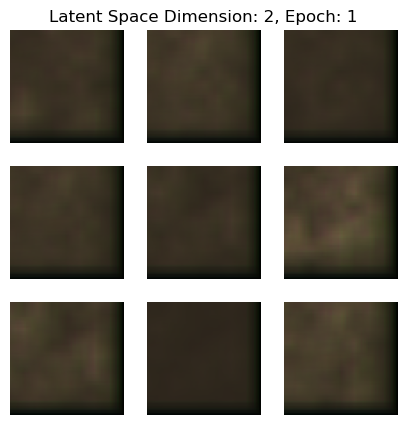

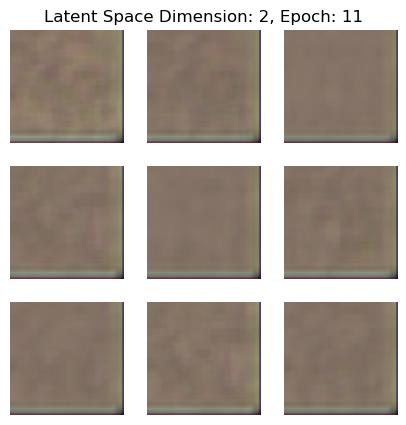

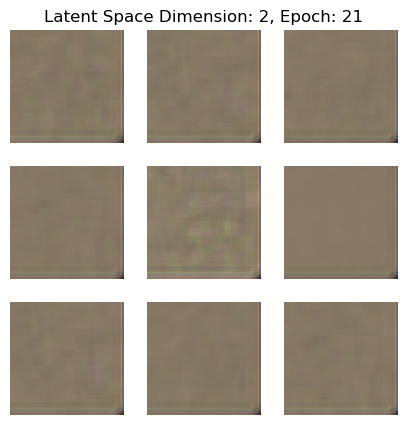

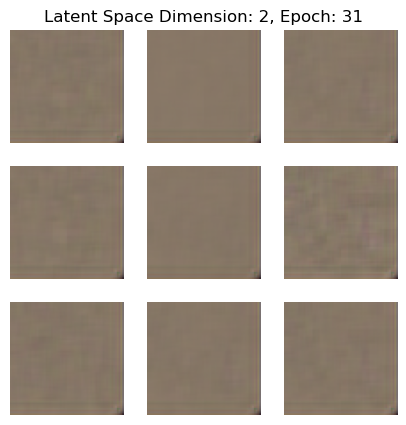

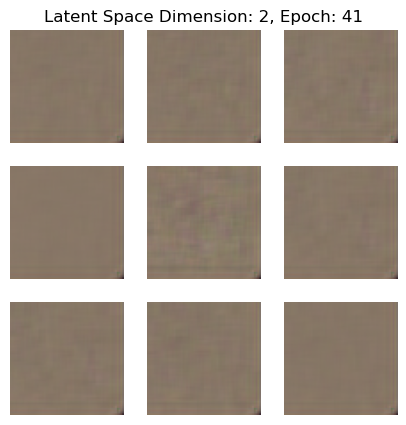

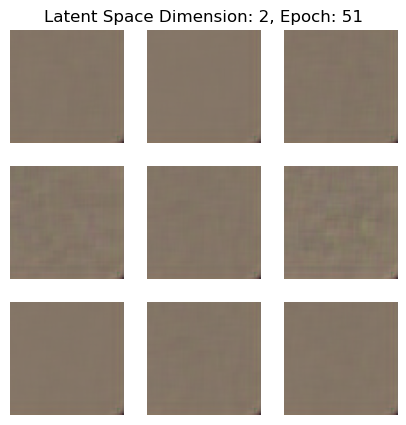

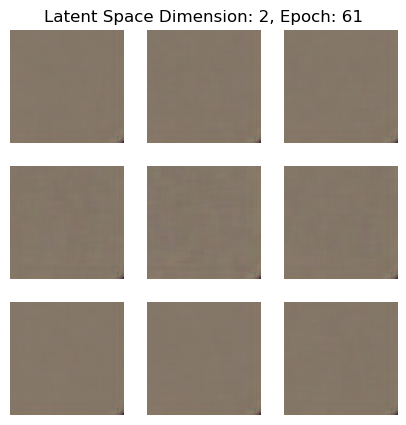

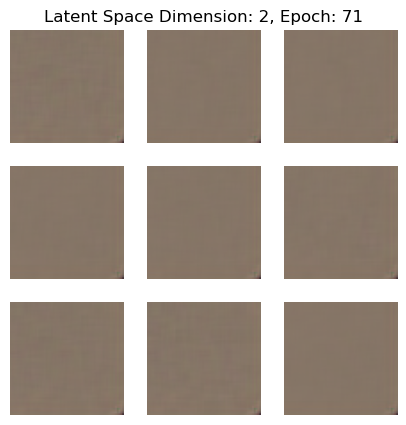

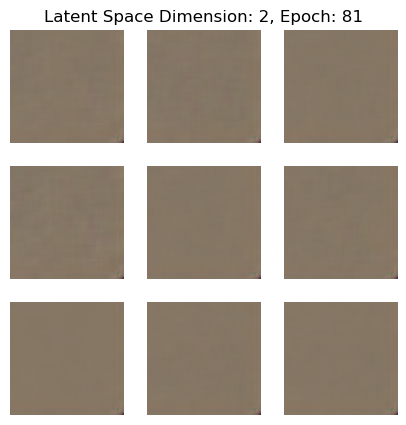

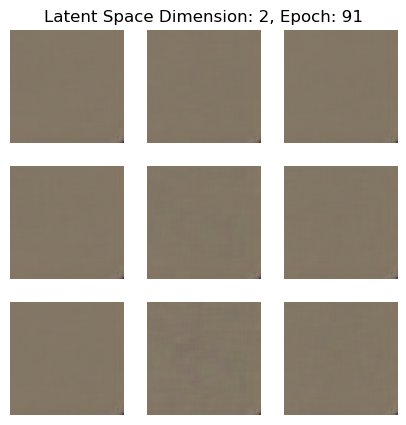

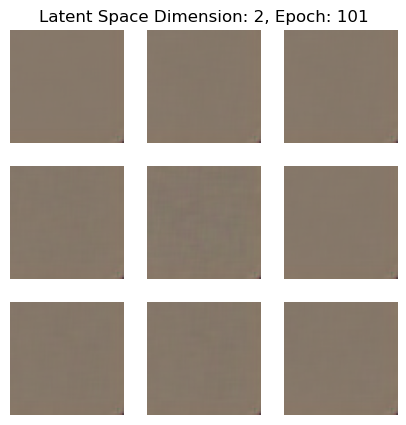

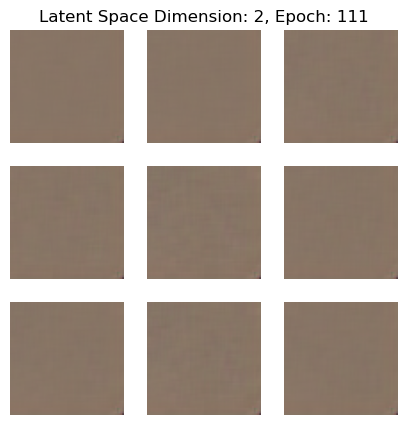

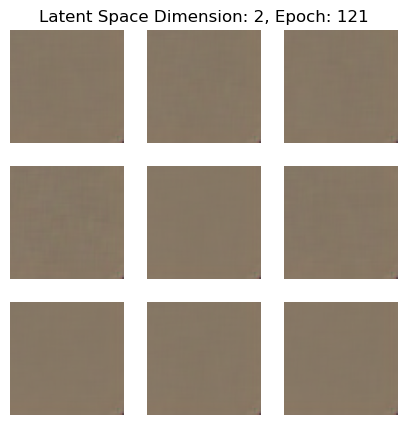

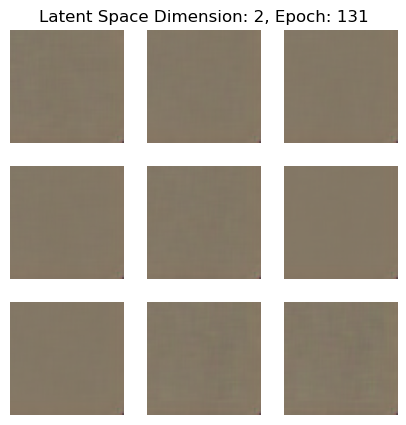

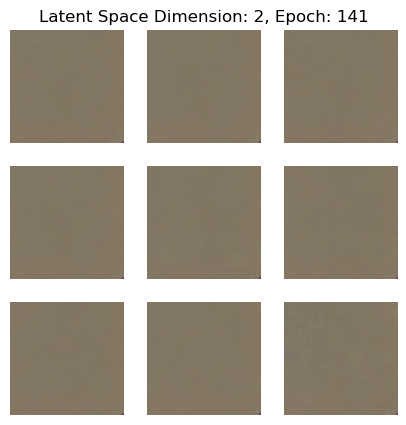

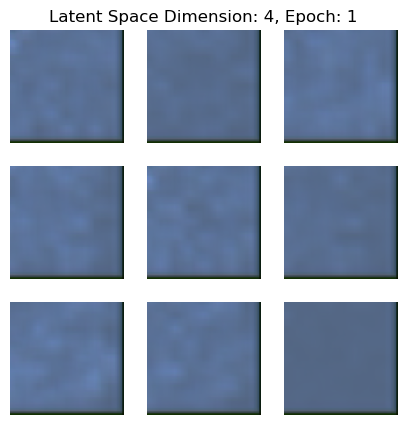

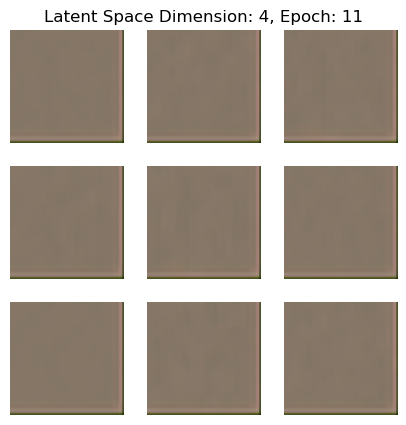

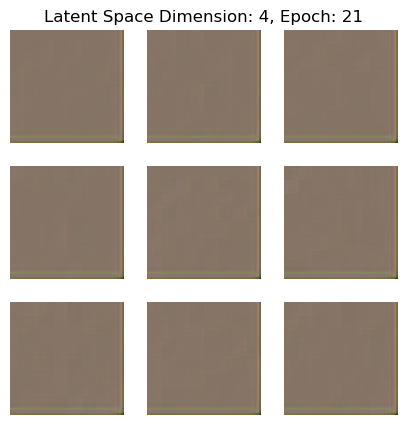

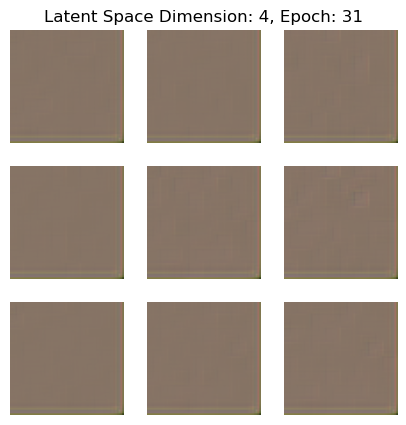

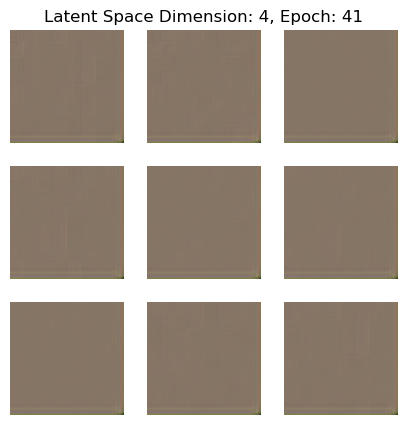

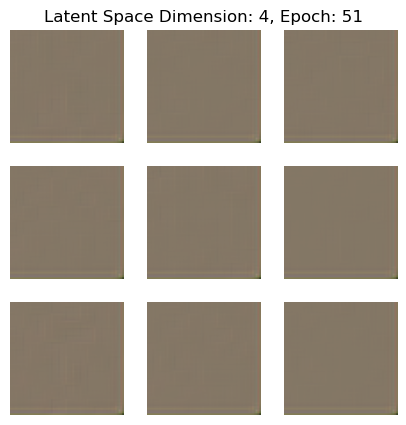

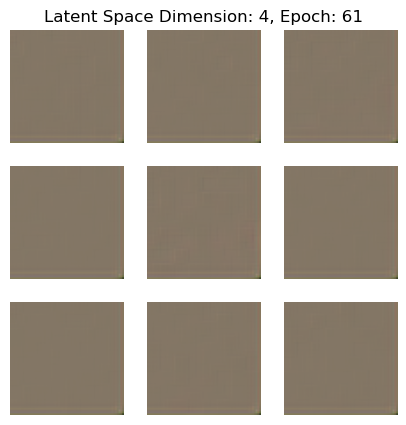

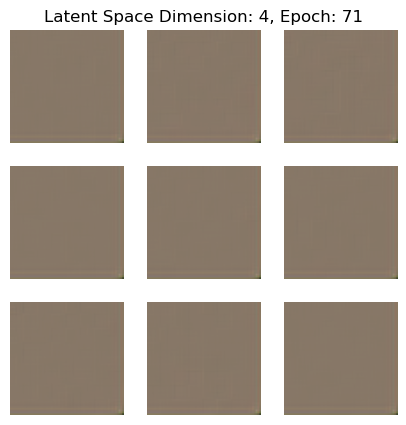

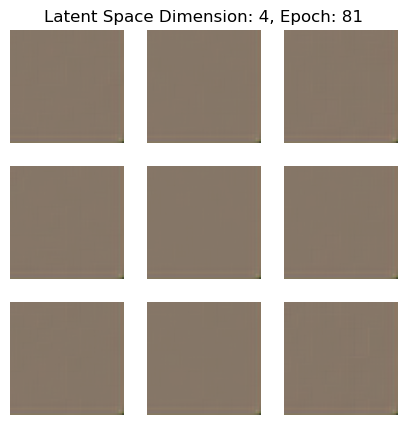

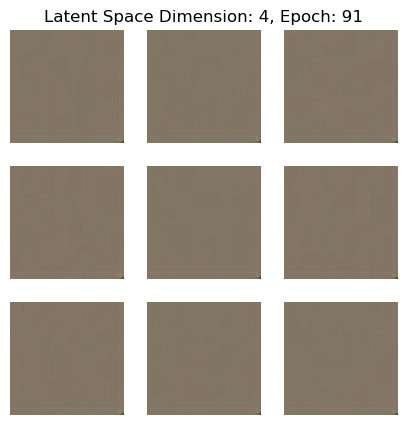

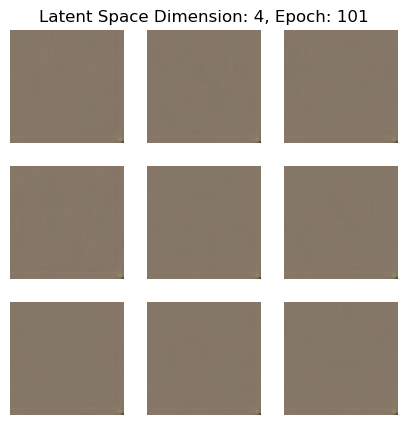

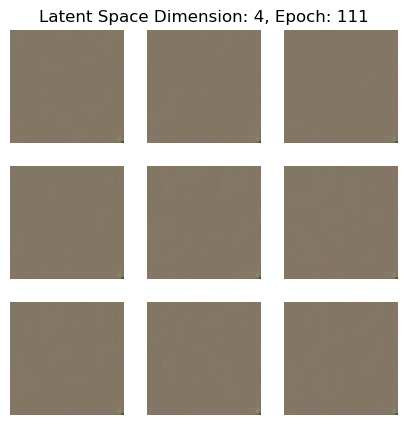

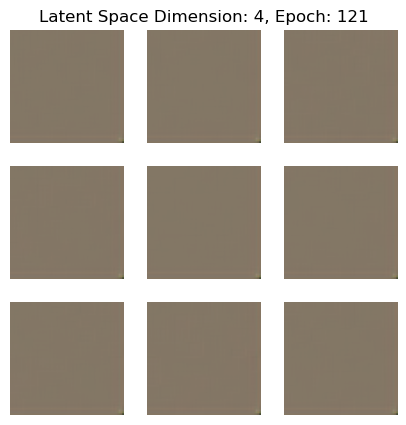

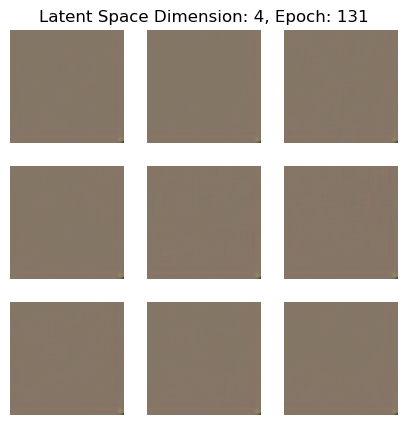

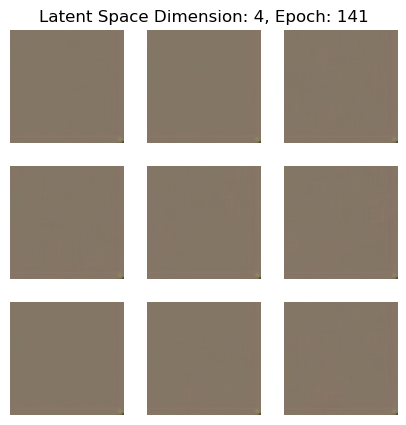

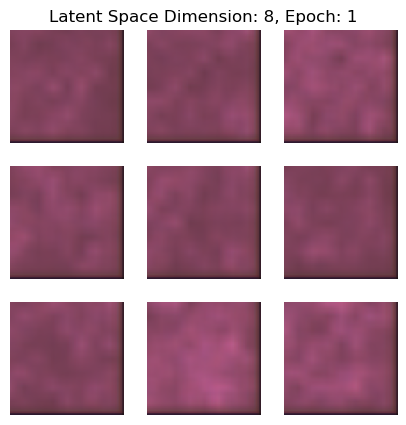

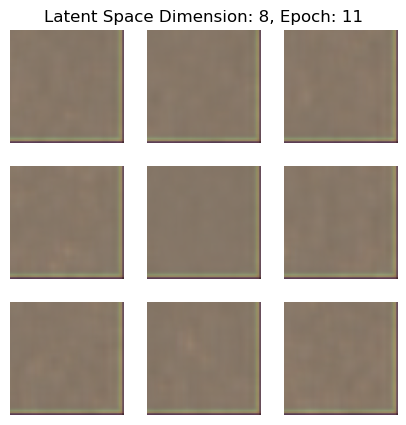

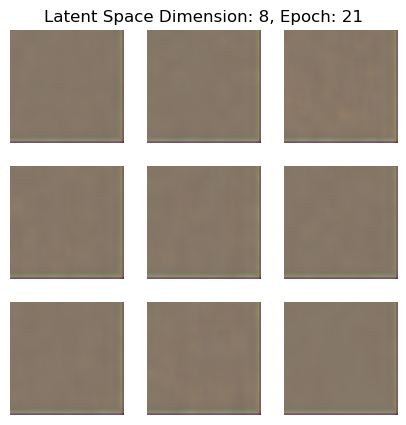

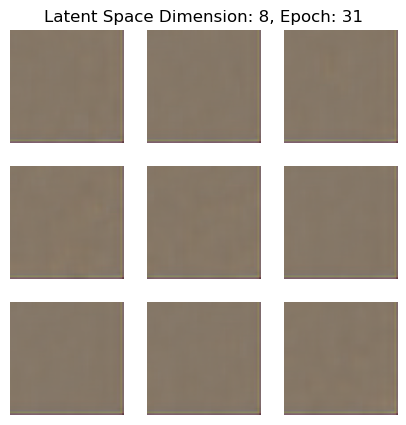

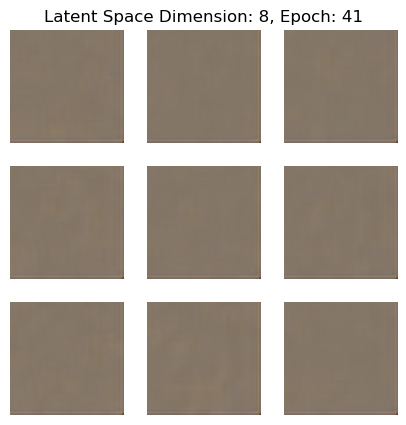

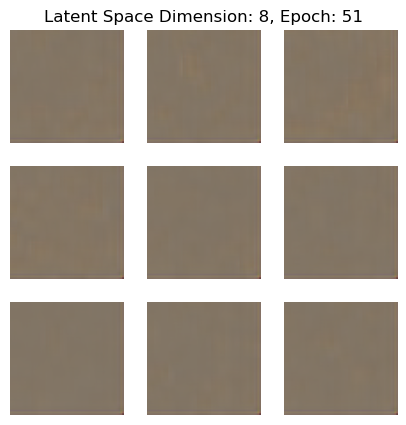

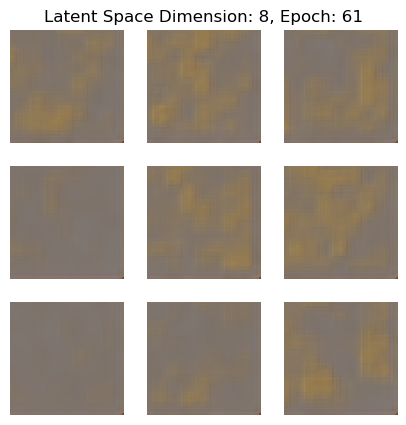

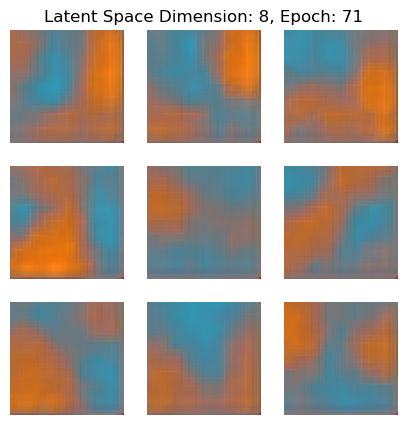

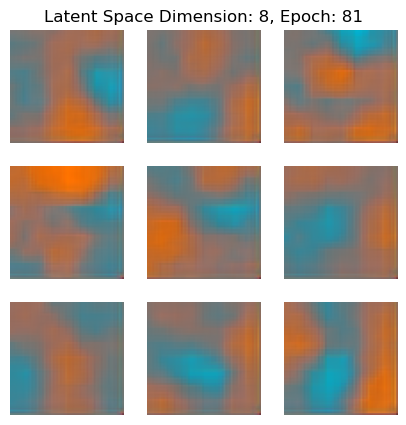

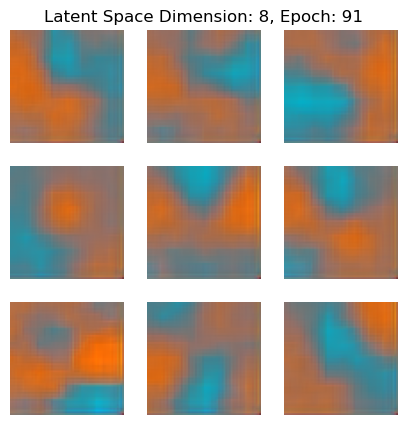

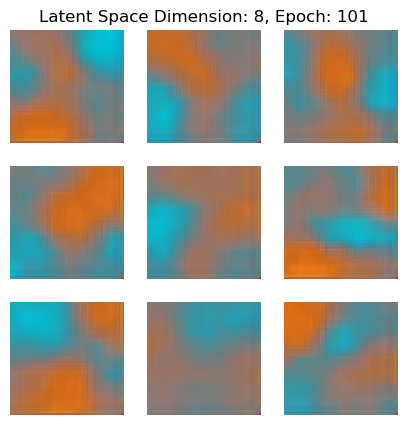

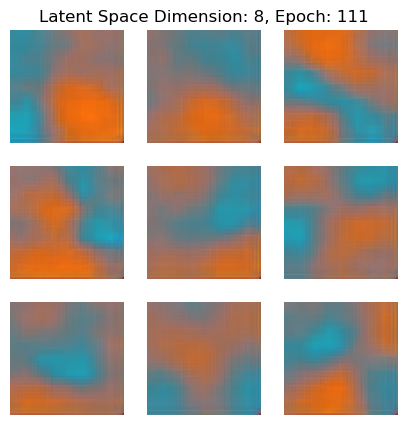

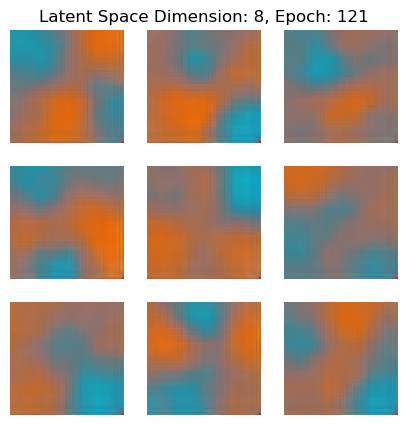

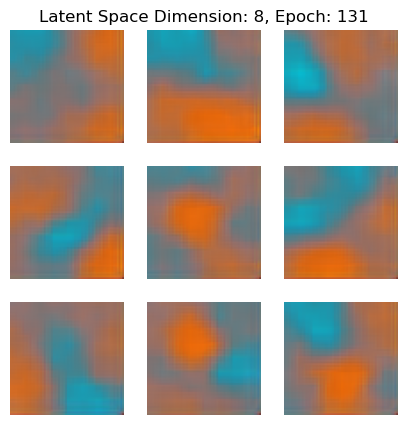

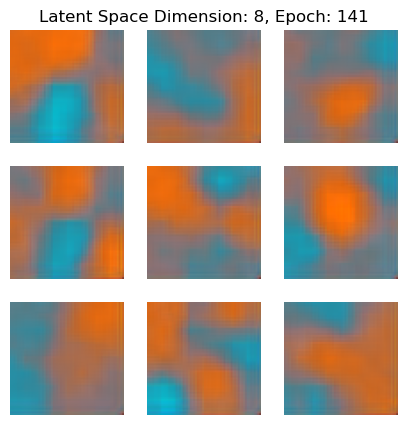

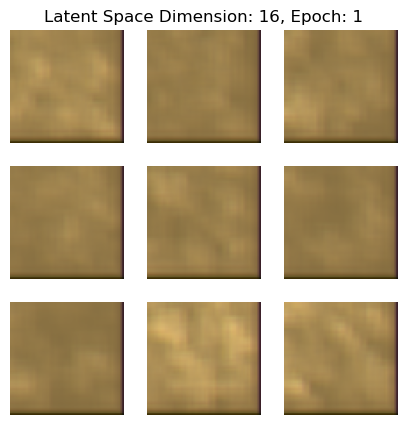

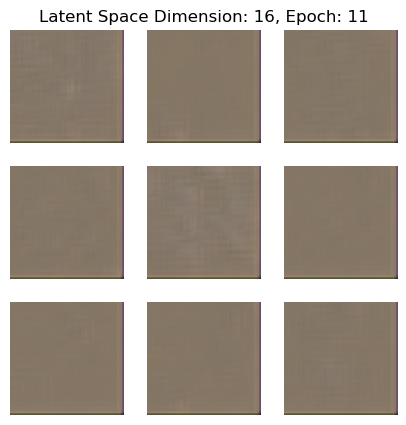

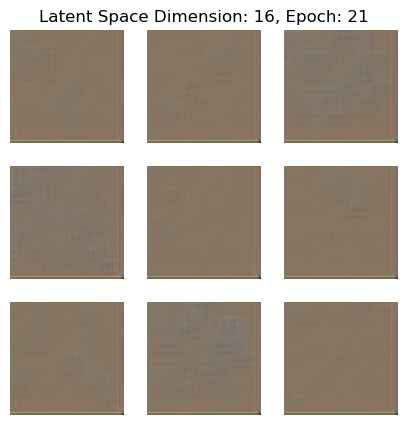

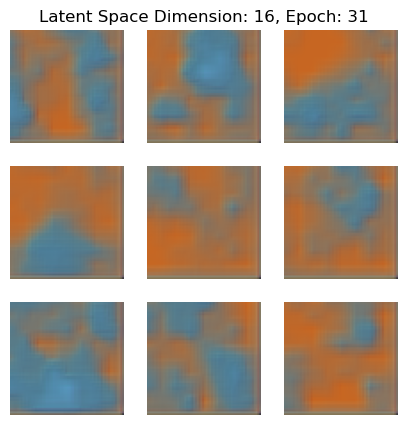

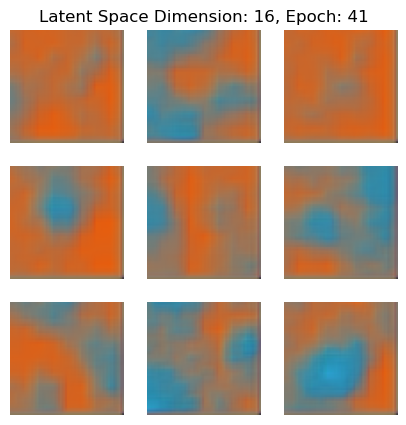

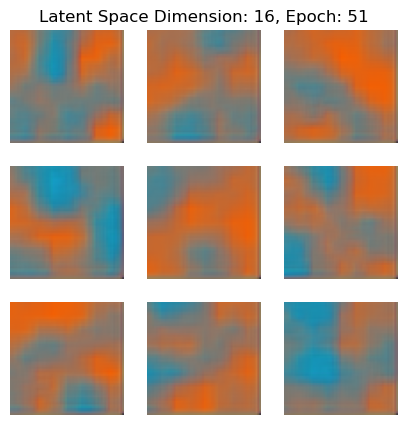

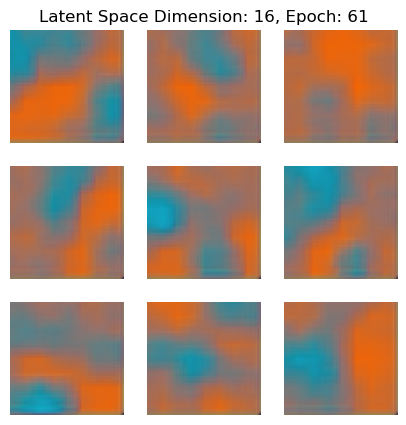

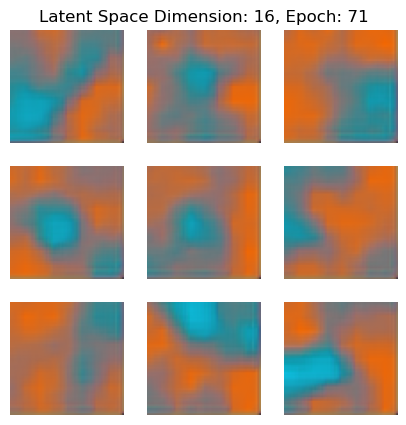

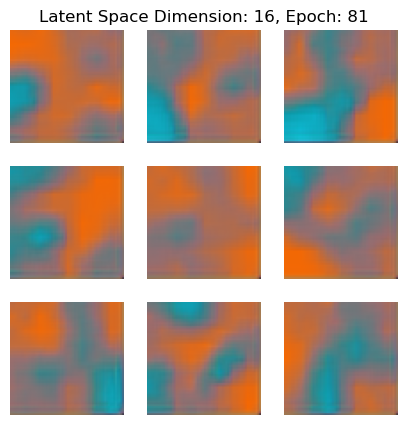

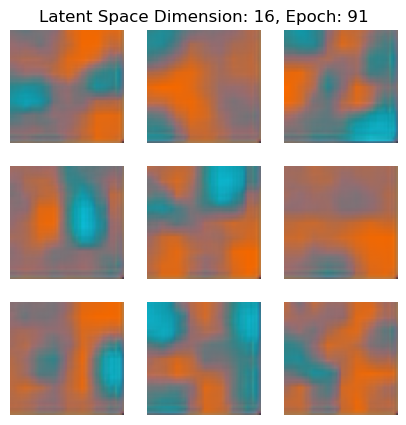

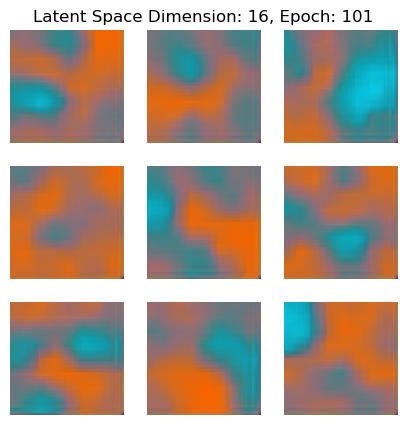

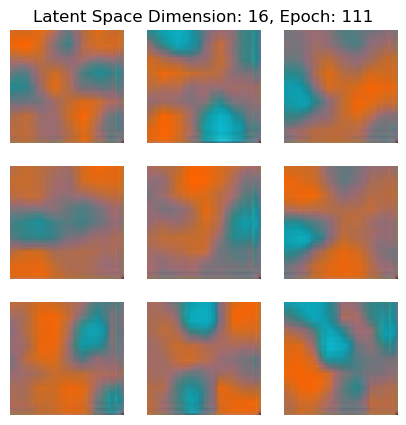

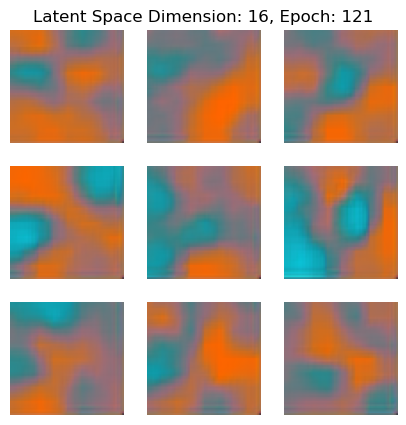

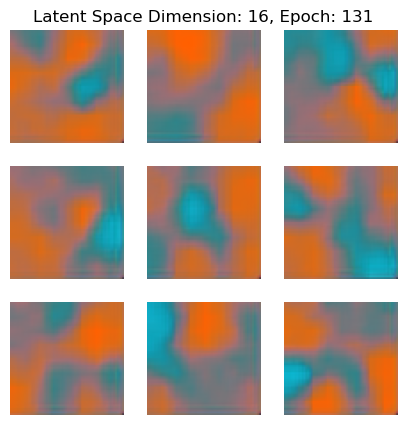

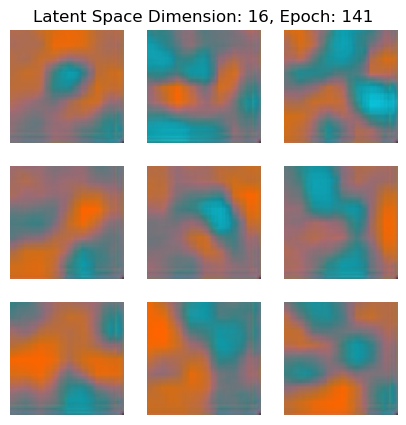

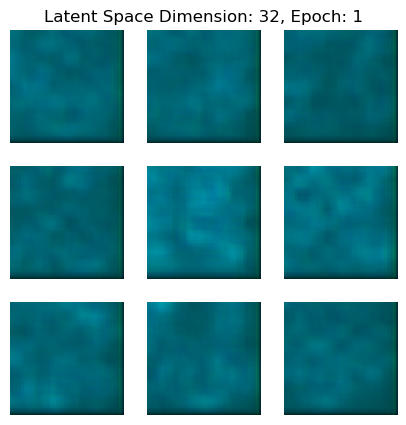

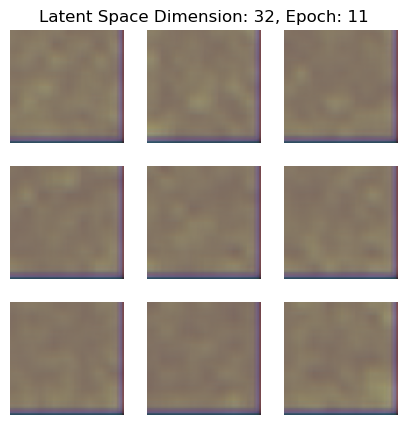

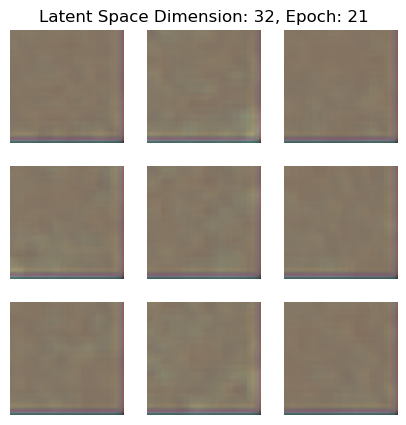

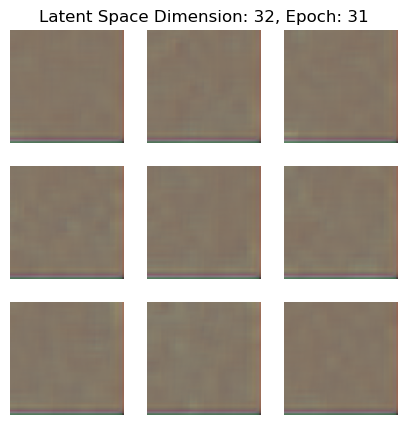

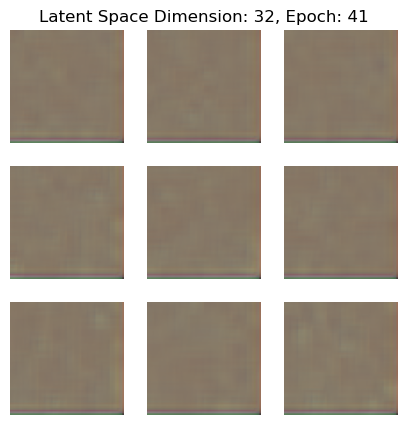

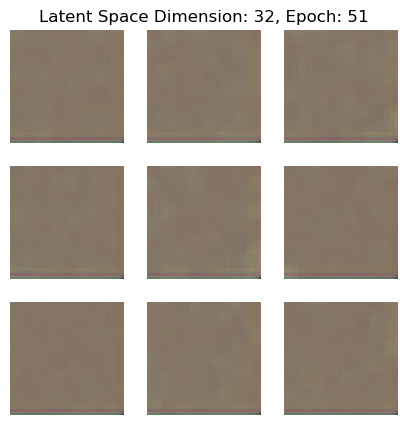

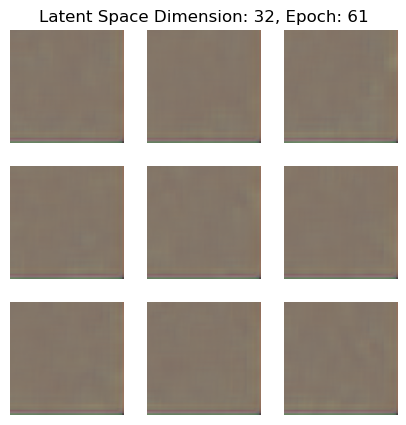

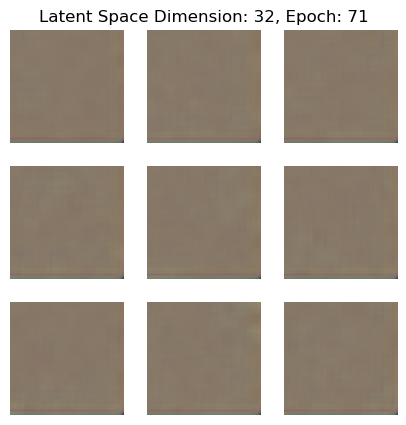

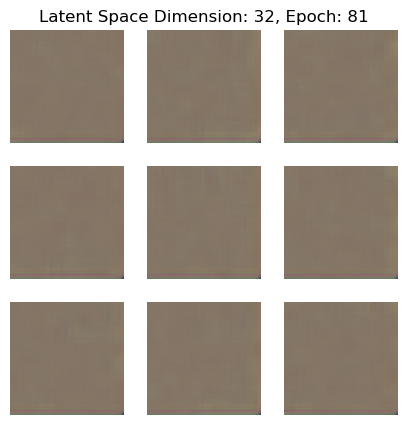

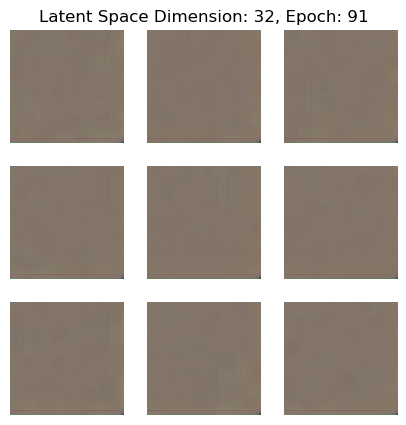

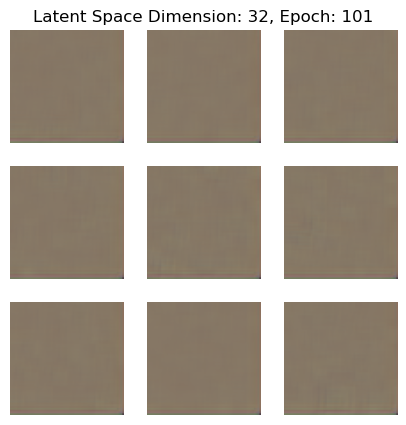

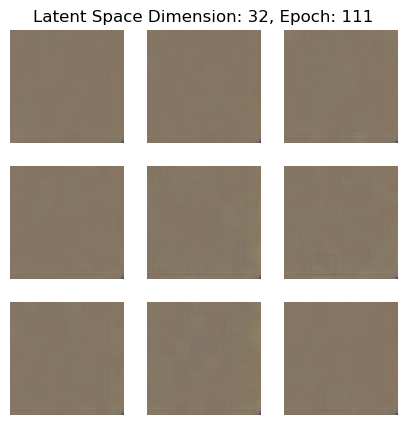

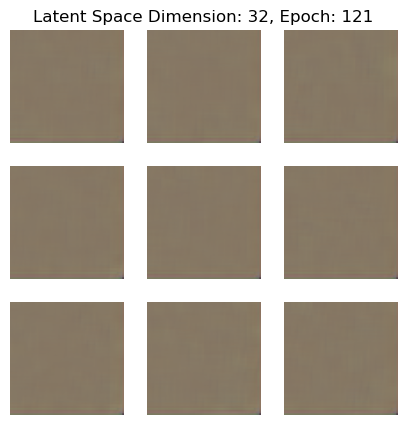

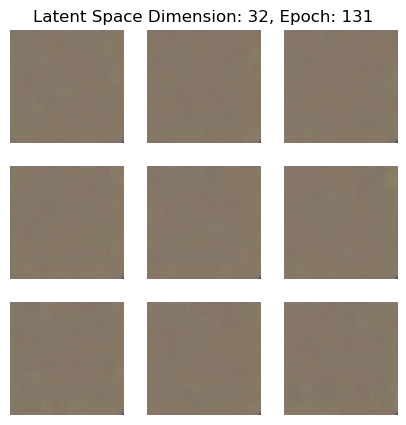

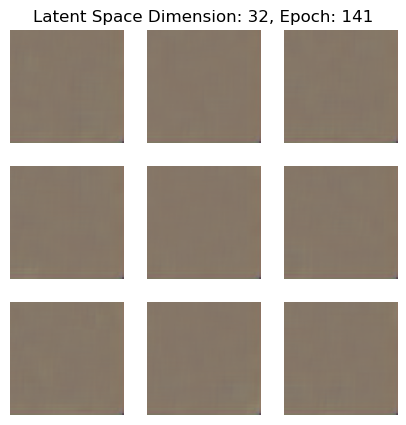

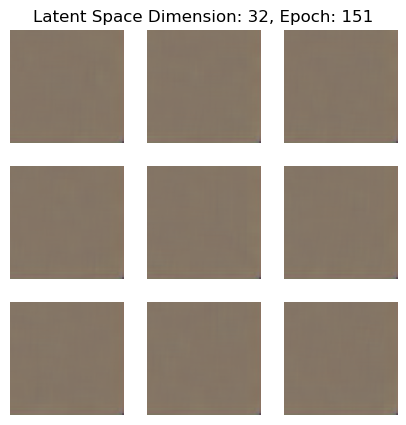

In [16]:
# Set the epochs
epochs = 151
# Train the data set for the architecture with different latent spaces
for latent_space_dimension in latent_space_dimension_list: 
    # Clear previous TensorFlow graph and session
    tf.keras.backend.clear_session()
    plt.close()
    print("STARTED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF: ", latent_space_dimension)
    # Get the encoder architecture 
    encoder = encoder_dict[latent_space_dimension]
    # Get the decoder architecture 
    decoder = decoder_dict[latent_space_dimension]
    # Get the overall architecture vae
    vae = architectures[latent_space_dimension]
    # Train
    architecture_loss = train(dataset,encoder,decoder,vae,latent_space_dimension,epochs=epochs,start_epoch=0)
    # Add the loss history to the loss_dict
    loss_dict[latent_space_dimension] = architecture_loss
    # Save the weights for the architecture
    generated_weights_folder = os.path.join(os.getcwd(),'weights')
    vae.save_weights(os.path.join(generated_weights_folder, f'weights_for_latent_space_{latent_space_dimension}'))
    print(f"COMPLETED: TRAINING THE ARCHITECTURE WITH A LATENT SPACE OF: {latent_space_dimension}.")
    print()
    print()
    print()

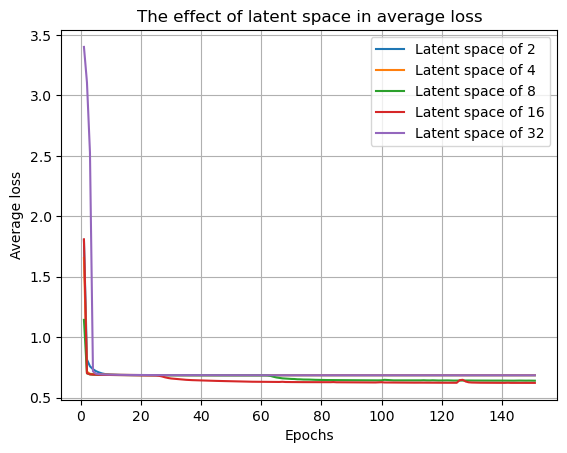

In [25]:
# Plotting loss values for chosen latent space dimensions in latent_space_dimension_list
for space_dim in loss_dict: 
    loss_data = loss_dict[space_dim]
    # Create x values from 1 to the length of loss_data
    x = list(range(1, len(loss_data) + 1))
    # Plot the line
    plt.plot(x, loss_data,'-',label=f"Latent space of {space_dim}")
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Average loss')
    plt.title('The effect of latent space in average loss')
    # Set the legend
    plt.legend()
    # Add a grid
    plt.grid()
# Save the plot
plt.savefig("The_effect_of_latent_space_in_average_loss")

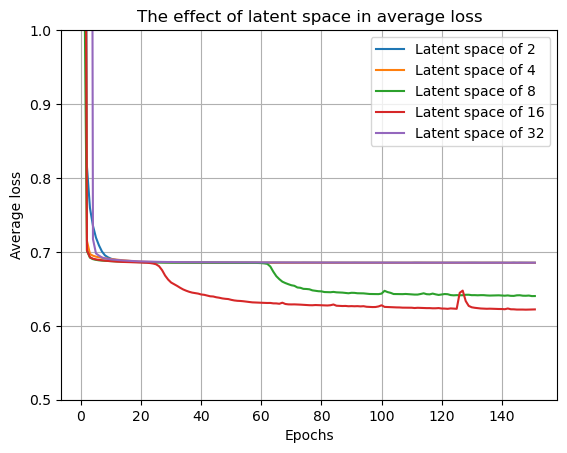

In [24]:
# Plotting loss values for chosen latent space dimensions in latent_space_dimension_list
for space_dim in loss_dict: 
    loss_data = loss_dict[space_dim]
    # Create x values from 1 to the length of loss_data
    x = list(range(1, len(loss_data) + 1))
    # Plot the line
    plt.plot(x, loss_data,'-',label=f"Latent space of {space_dim}")
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Average loss')
    plt.title('The effect of latent space in average loss')
    # Set the legend
    plt.legend()
    # Add a grid
    plt.grid()
# Set the axis limit
plt.ylim(0.5, 1)  # Set the y-axis limits
# Save the plot
plt.savefig("Zoomed_The_effect_of_latent_space_in_average_loss")

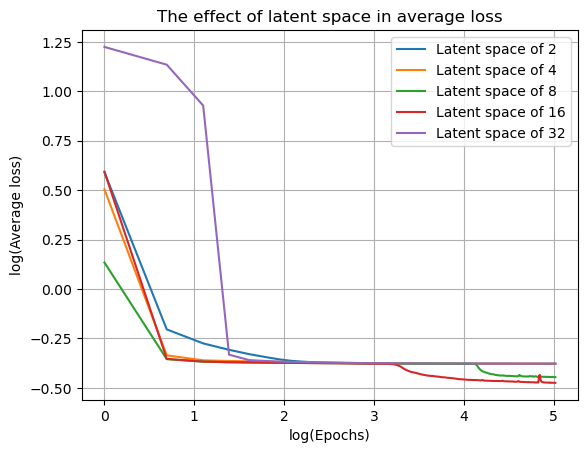

In [23]:
import math
# Logarithmic - Plotting loss values for chosen latent space dimensions in latent_space_dimension_list
for space_dim in loss_dict: 
    loss_data = loss_dict[space_dim]
    loss_data = [math.log(x) for x in loss_data]
    # Create x values from 1 to the length of loss_data
    x_l = list(range(1, len(loss_data) + 1))
    x_l = [math.log(x) for x in x_l]
    # Plot the line
    plt.plot(x_l, loss_data,'-',label=f"Latent space of {space_dim}")
    # Add labels and title
    plt.xlabel('log(Epochs)')
    plt.ylabel('log(Average loss)')
    plt.title('The effect of latent space in average loss')
    # Set the legend
    plt.legend()
    # Add a grid
    plt.grid()

# Save the plot
plt.savefig("log_log_The_effect_of_latent_space_in_average_loss")